# Non-B-DNA structures in centromeric arrays
## find palindromes
palindrome function from EMBOSS conda package
used according to doi:10.1093/molbev/msy010
```bash
name='lusy1_nonfunctional_arrays'
palindrome -sequence functional_arrays/${name}.fasta -minpallen 4 -maxpallen 100 -gaplimit 20 -nummismatches 0 –overlap -outfile nonB/${name}.palindrome
```
### parse output

In [4]:
def parse_palindromes(file):
    import pandas as pd

    # Initialize a list to store data
    data = []
    previous_line = ''
    fasta_index = 0
    fasta_length = 0

    with open(file, 'r') as file:
        for line in file:
            
            if line.startswith('Sequence length is:'):
                # Start of a new fasta sequence
                fasta_index += 1
                fasta_length = int(line.split(':')[1].strip())
            
            elif line[0].isdigit():
                if '|' not in previous_line:
                    start1, sequence1, end1 = line.split()
                elif '|' in previous_line:
                    start2, sequence2, end2 = line.split()
                    data.append([fasta_index, fasta_length, start1, end1, sequence1, start2, end2, sequence2])
            previous_line = line
    # Create a DataFrame from the list
    df = pd.DataFrame(data, columns=['fasta_index', 'fasta_length', 'start1', 'end1', 'sequence1', 'start2', 'end2', 'sequence2'])

    # Optionally, convert columns to appropriate data types
    df = df.astype({'fasta_index': int, 'fasta_length': int, 'start1': int, 'end1': int, 'start2': int, 'end2': int})

    return df

In [5]:
files_dict = {}
files_dict['lusy1_centromeric'] = 'data/nonB/lusy1_functional_fragments.palindrome'
files_dict['lusy1_noncentromeric'] = 'data/nonB/lusy1_nonfunctional_arrays.palindrome'
files_dict['lusy2_centromeric'] = 'data/nonB/lusy2_functional_fragments.palindrome'
files_dict['lusy2_noncentromeric'] = 'data/nonB/lusy2_nonfunctional_arrays.palindrome'

palindrome_densities = {}
for key, value in files_dict.items():
    df = parse_palindromes(value)
    # Count palindromes in each fasta_index to new column
    palindrome_counts = df.groupby(['fasta_index', 'fasta_length']).size().reset_index(name='palindrome_count')
    palindrome_counts['palindrome_density'] = palindrome_counts['palindrome_count'] / palindrome_counts['fasta_length'] * 1000
    palindrome_densities[key] = palindrome_counts


Two-tailed Mann-Whitney U test for Lusy1:
MannwhitneyuResult(statistic=84758.0, pvalue=3.9750618896790706e-28)
Two-tailed Mann-Whitney U test for Lusy2:
MannwhitneyuResult(statistic=47812.5, pvalue=0.3310704384180626)


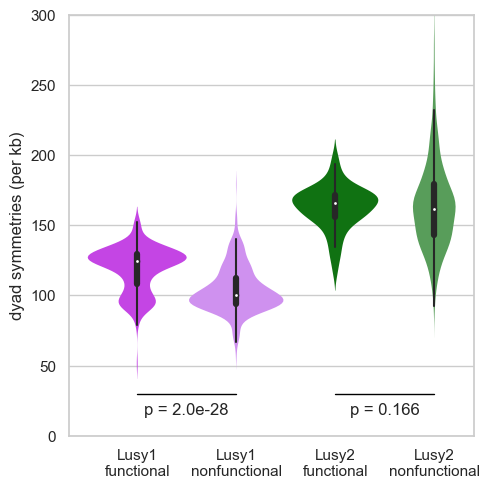

In [6]:
# create boxplot of palindrome densities

# calculate two-tailed mann-whitey test between centromeric and noncentromeric arrays
from scipy import stats
lusy1_centromeric = palindrome_densities['lusy1_centromeric']['palindrome_density']
lusy1_noncentromeric = palindrome_densities['lusy1_noncentromeric']['palindrome_density']
lusy2_centromeric = palindrome_densities['lusy2_centromeric']['palindrome_density']
lusy2_noncentromeric = palindrome_densities['lusy2_noncentromeric']['palindrome_density']
print('Two-tailed Mann-Whitney U test for Lusy1:')
print(stats.mannwhitneyu(lusy1_centromeric, lusy1_noncentromeric))
print('Two-tailed Mann-Whitney U test for Lusy2:')
print(stats.mannwhitneyu(lusy2_centromeric, lusy2_noncentromeric))

# concatenate all palindrome densities into one dataframe with a new column for dataset
import pandas as pd

def patch_violinplot():
     from matplotlib.collections import PolyCollection
     ax = plt.gca()
     for art in ax.get_children():
          if isinstance(art, PolyCollection):
              
              art.set_edgecolor('none')

df = pd.DataFrame()
for dataset, palindrome_counts in palindrome_densities.items():
    palindrome_counts['dataset'] = dataset
    df = pd.concat([df, palindrome_counts])
import matplotlib.pyplot as plt
import seaborn as sns
short_labels=['Lusy1\nfunctional', 'Lusy1\nnonfunctional', 'Lusy2\nfunctional', 'Lusy2\nnonfunctional']
colors = ['#d42afff1', '#d481fff8', '#008203ff', '#4da84ff8']
sns.set_theme(style="whitegrid")
plt.figure(figsize=(5, 5))
sns.violinplot(x="dataset", y="palindrome_density", data=df,palette=colors, width=1)
plt.xticks(range(4), short_labels)
plt.xlabel('')
plt.ylabel('dyad symmetries (per kb)')
plt.tight_layout()
plt.ylim(0, 300)
# add significance bars
plt.plot([0, 1], [30, 30], linewidth=1, color='black')
plt.plot([2, 3], [30, 30], linewidth=1, color='black')
plt.text(0.5, 15, 'p = {0:.1e}'.format(stats.mannwhitneyu(lusy1_centromeric, lusy1_noncentromeric, alternative='greater')[1]), horizontalalignment='center')
plt.text(2.5, 15, 'p = {0:.3}'.format(stats.mannwhitneyu(lusy2_centromeric, lusy2_noncentromeric, alternative='greater')[1]), horizontalalignment='center')
patch_violinplot()
plt.savefig('data/figures/palindrome_density.svg')
plt.show()
